![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/open-source-nlp/15.0.Table_Question_Answering.ipynb)

## TAPAS for Table Question Answering using Spark NLP 🚀

[TAPAS](https://arxiv.org/abs/2004.02349) is a Zero-shot Question Answering architecture, based on Bert, to carry out Table Understanding. By asking a question on natural language using these models, you can retrieve the content of the cell or cells which best answer to those questions.


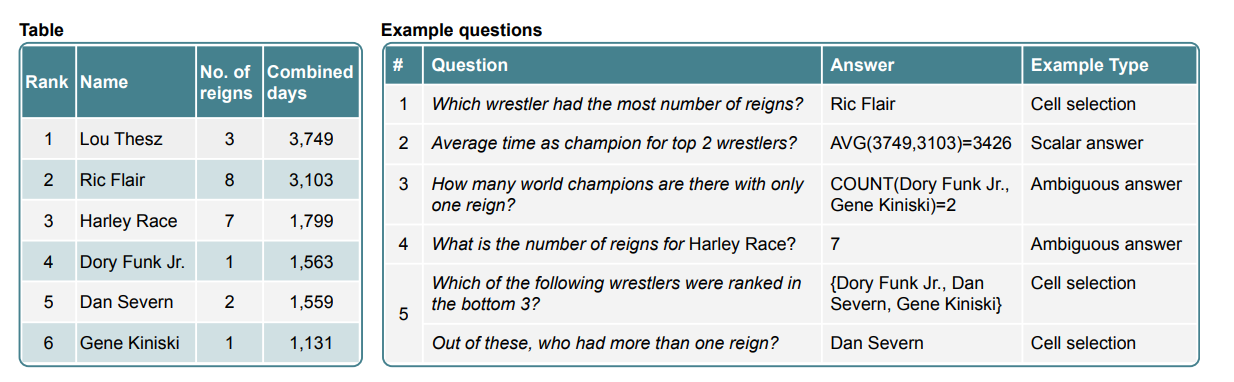



Our approach works on Spark Dataframes, which means that, if you have your tables in files, you need to load them first.

Doin't forget to load the headers of the tables, which are very meaningful for the model.

This feature is only available in `Spark NLP 4.2.0` and above. So please make sure you have upgraded to the latest Spark NLP release.

TAPAS models have been trained using a combination of three datasets:
- [SQA](https://www.microsoft.com/en-us/download/details.aspx?id=54253), Sequential Question Answering by Microsoft (it was not trained to return aggregation operations as SUM, COUNT, etc - see below)
- [WTQ](https://github.com/ppasupat/WikiTableQuestions), Wiki Table Questions by Stanford University (with aggregation operations)
- [WikiSQL](https://github.com/salesforce/WikiSQL), by Salesforce, also with aggregation operations.

As mentioned before, TAPAS models can return aggregation operation, if they are trained to do so:
-  All WTQ or WikiSQL models  returning those operations as part of the answer to the qustion, if required. The operations are: AVERAGE, SUM, COUNT.
- SQA models don't return any aggregation operation, just the answer in human language.

# Using pretrained TAPAS models in Spark NLP 🚀

## Creating a Session

In [ ]:
!wget https://setup.johnsnowlabs.com/colab.sh -O - | bash /dev/stdin -p 3.4.1 -s 5.1.2 -g

In [2]:
#Start Spark
import sparknlp
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import TapasForQuestionAnswering, SentenceDetector
from sparknlp.base import MultiDocumentAssembler, TableAssembler

spark = sparknlp.start()

In [3]:
spark

## Let's create an example table and some questions

In [4]:
json_data = """
{
  "header": ["name", "money", "age"],
  "rows": [
    ["Donald Trump", "$100,000,000", "75"],
    ["Elon Musk", "$20,000,000,000,000", "55"]
  ]
}
"""

queries = [
    "Who earns less than 200,000,000?",
    "Who earns 100,000,000?",
    "How much money has Donald Trump?",
    "How old are they?",
]

## TAPAS needs a specific annotator, called `MultiDocumentAssembler` to assemble the table and the questions.


In [5]:
data = spark.createDataFrame([
        [json_data, " ".join(queries)]
    ]).toDF("table_json", "questions")

document_assembler = MultiDocumentAssembler() \
    .setInputCols("table_json", "questions") \
    .setOutputCols("document_table", "document_questions")

In [6]:
sentence_detector = SentenceDetector() \
    .setInputCols(["document_questions"]) \
    .setOutputCol("questions")

## Then, we tell  Spark NLP to manage `document_table` column as a table using a new annotator, `TableAssembler`

In [7]:
table_assembler = TableAssembler()\
    .setInputCols(["document_table"])\
    .setOutputCol("table")

## Last component is `TapasForQuestionAnswering`, which will carry out the inference process

In [8]:
tapas = TapasForQuestionAnswering\
    .pretrained("table_qa_tapas_base_finetuned_wtq", "en")\
    .setInputCols(["questions", "table"])\
    .setOutputCol("answers")

table_qa_tapas_base_finetuned_wtq download started this may take some time.
Approximate size to download 394.7 MB
[OK!]


## The pipeline looks like as follows:

In [9]:
pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    table_assembler,
    tapas
])

# And this is the result on fit/transform

In [10]:
model = pipeline.fit(data)
model\
    .transform(data)\
    .selectExpr("explode(answers) AS answer")\
    .select("answer")\
    .show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|answer                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|{chunk, 0, 12, Donald Trump, {question -> Who earns less than 200,000,000?, aggregation -> NONE, cell_positions -> [0, 0], cell_scores -> 1.0}, []}    |
|{chunk, 0, 12, Donald Trump, {question -> Who earns 100,000,000?, aggregation -> NONE, cell_positions -> [0, 0], cell_scores -> 1.0}, []}              |
|{chunk, 0, 17, SUM($100,000,000), {question -> How much money has Donald Trump?, aggregation -> SUM, cell_positions -> [1, 0], cell_scores -> 1.0}, []}|
|{chunk, 0, 15, AVERAGE(75, 55), {question -> How old are they?, aggregation